In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim
import tqdm

# Generate data

In [2]:
input_x = np.random.uniform(0, 3, size=1000)
output_y = np.round(input_x + np.random.randn(1000) * 0.05)

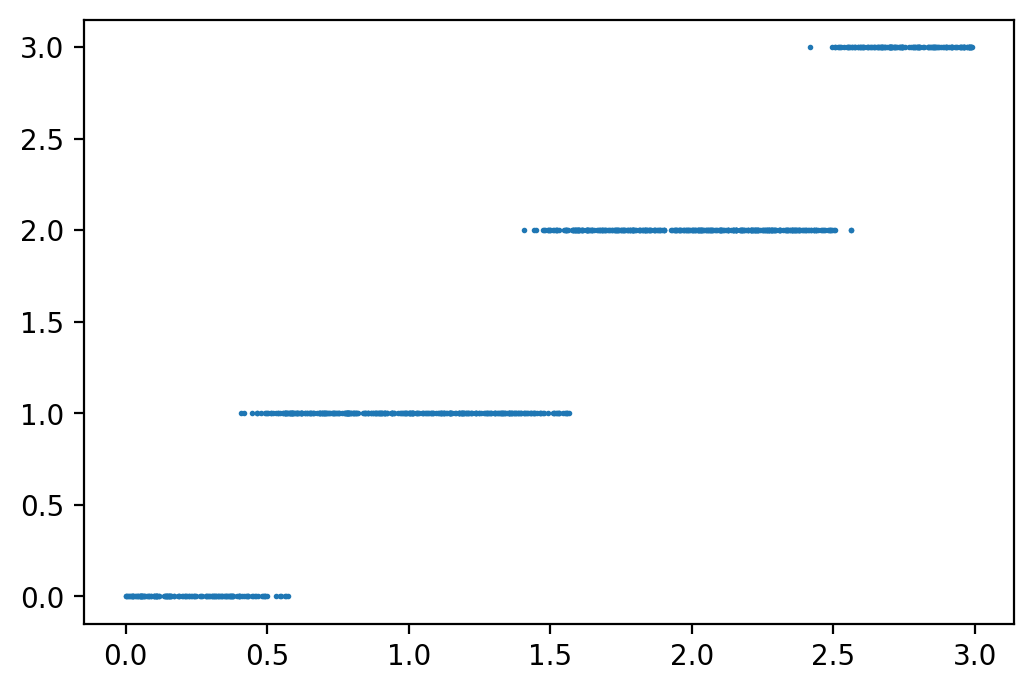

In [3]:
plt.figure(dpi=200)
plt.scatter(input_x, output_y, s=1)

# Sigma model

In [4]:
class SigmaModule(nn.Module):
    def __init__(self):
        super().__init__()
        self._classificator = nn.Linear(1, 3)
        self._regressor = nn.Linear(3, 1)
    
    def forward(self, x):
        x = self._classificator(x)
        x = torch.sigmoid(x)
        x = self._regressor(x)
        return x

In [22]:
model = SigmaModule()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-1)

In [23]:
input_data = torch.tensor(input_x[:, None].astype(np.float32))
output_data = torch.tensor(output_y[:, None].astype(np.float32))
losses = []
iteration_count = 10000
for i in tqdm.tqdm(range(iteration_count)):
    model.zero_grad()
    predicted = model(input_data)
    loss = loss_function(predicted, output_data)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1684.92it/s]


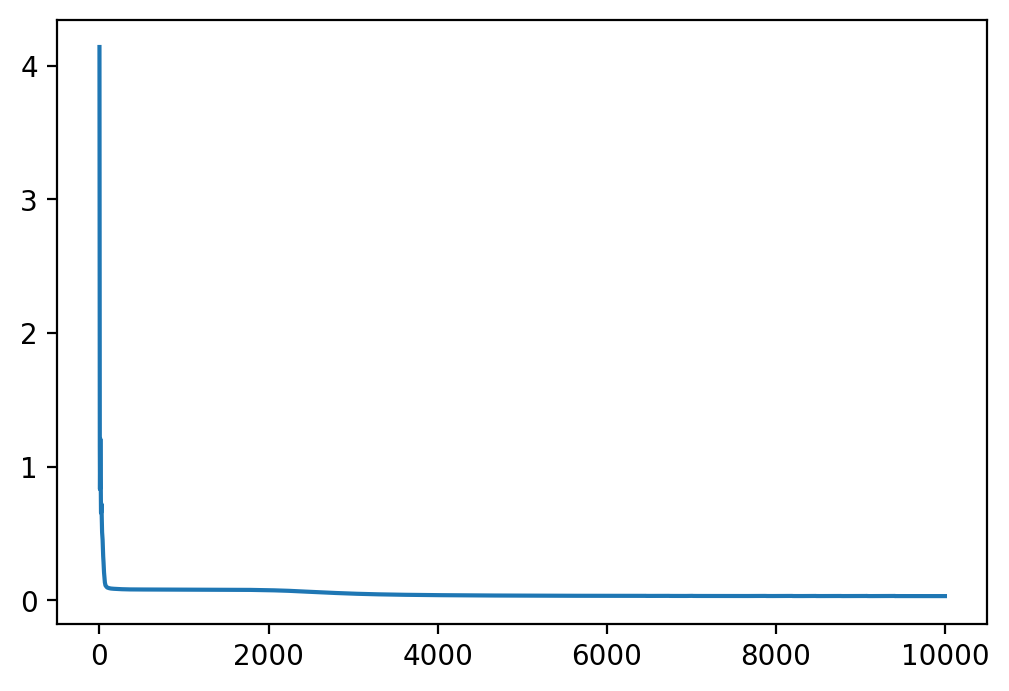

In [24]:
plt.figure(dpi=200)
plt.plot(losses)

In [25]:
losses[-1]

0.031313613057136536

In [26]:
final_predicted = model(input_data).detach().cpu().numpy()[:, 0]

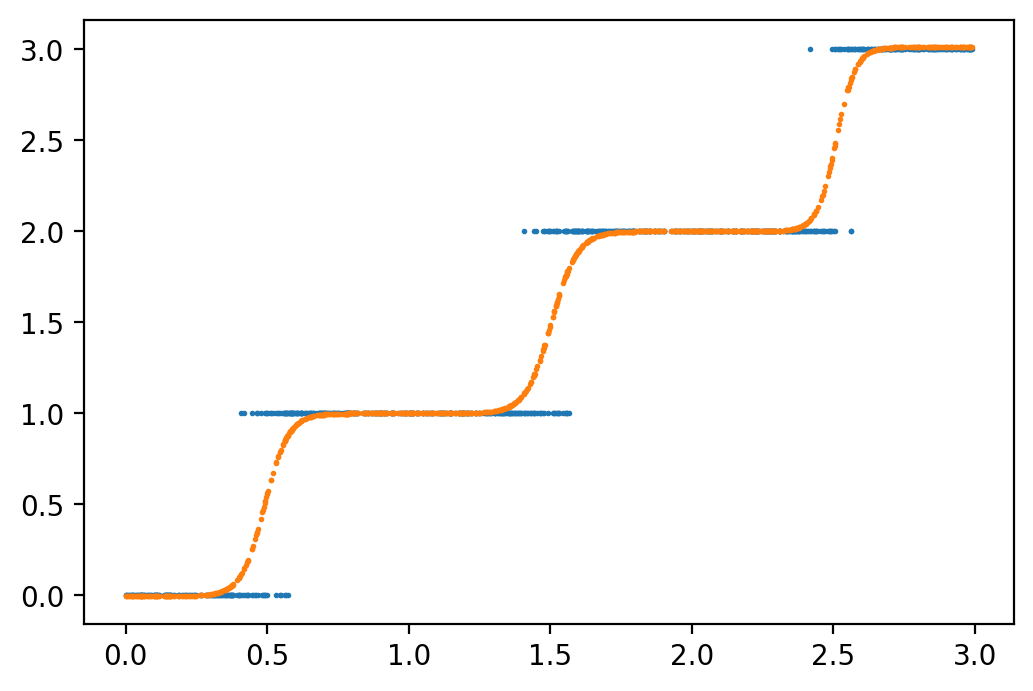

In [27]:
plt.figure(dpi=200)
plt.scatter(input_x, output_y, s=1)
plt.scatter(input_x, final_predicted, s=1)

In [47]:
class SigmaStochasticModule(nn.Module):
    def __init__(self):
        super().__init__()
        self._classificator = nn.Linear(1, 3)
        self._regressor = nn.Linear(3, 1)
    
    def forward(self, x):
        x = self._classificator(x)
        probability = torch.sigmoid(x)
        a = torch.bernoulli(probability)
        c = (a - probability).detach()
        x = c + probability
        x = self._regressor(x)
        return x

In [48]:
model = SigmaStochasticModule()
loss_function = nn.HuberLoss(delta=0.1)
optimizer = torch.optim.Adam(model.parameters(), 1e-1)
input_data = torch.tensor(input_x[:, None].astype(np.float32))
output_data = torch.tensor(output_y[:, None].astype(np.float32))
losses = []
iteration_count = 10000
for i in tqdm.tqdm(range(iteration_count)):
    model.zero_grad()
    predicted = model(input_data)
    loss = loss_function(predicted, output_data)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1525.64it/s]


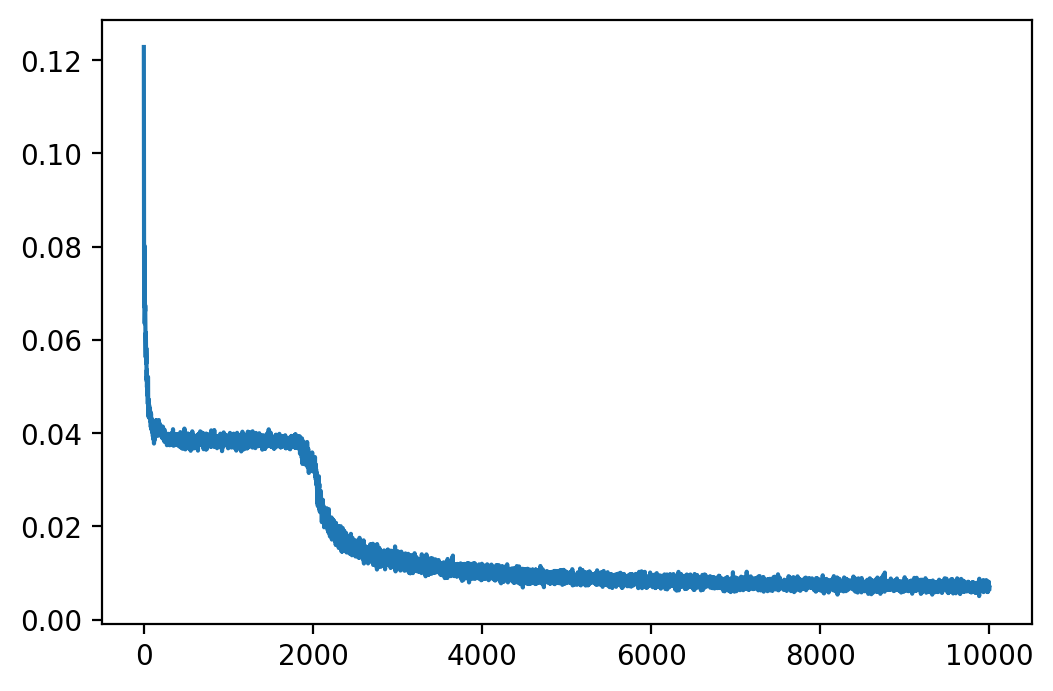

In [49]:
plt.figure(dpi=200)
plt.plot(losses)

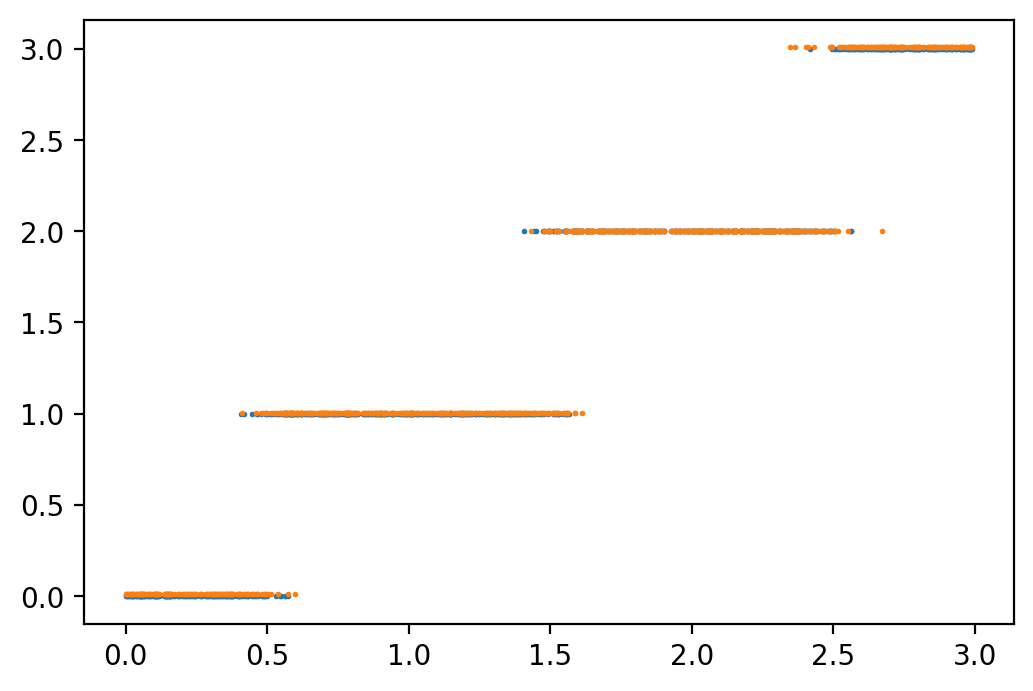

In [50]:
final_predicted = model(input_data).detach().cpu().numpy()[:, 0]
plt.figure(dpi=200)
plt.scatter(input_x, output_y, s=1)
plt.scatter(input_x, final_predicted, s=1)

In [51]:
losses[-1]

0.006659865844994783

# Score function stochastic varaiance inference

In [39]:
class SigmaScoreFunctionModule(nn.Module):
    def __init__(self):
        super().__init__()
        self._classificator = nn.Linear(1, 3)
        self._regressor = nn.Linear(3, 1)
    
    def forward(self, x):
        x = self._classificator(x)
        probability = torch.sigmoid(x)
        a = torch.bernoulli(probability).detach()
        x = self._regressor(a)
        return x, torch.log(a * probability + (1 - a) * (1 - probability))

In [40]:
model = SigmaScoreFunctionModule()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-1)
input_data = torch.tensor(input_x[:, None].astype(np.float32))
output_data = torch.tensor(output_y[:, None].astype(np.float32))
losses = []
iteration_count = 10000
for i in tqdm.tqdm(range(iteration_count)):
    model.zero_grad()
    predicted, log_prob = model(input_data)
    loss = loss_function(predicted, output_data)
    loss = loss + torch.sum(log_prob) * loss.detach()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1301.06it/s]


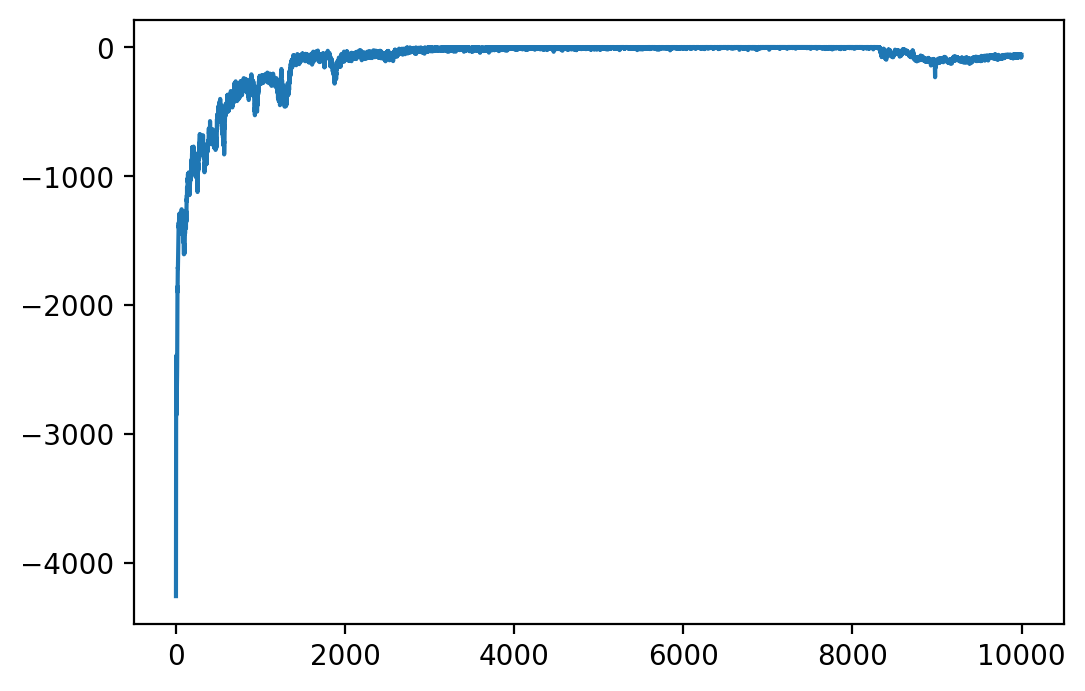

In [41]:
plt.figure(dpi=200)
plt.plot(losses)

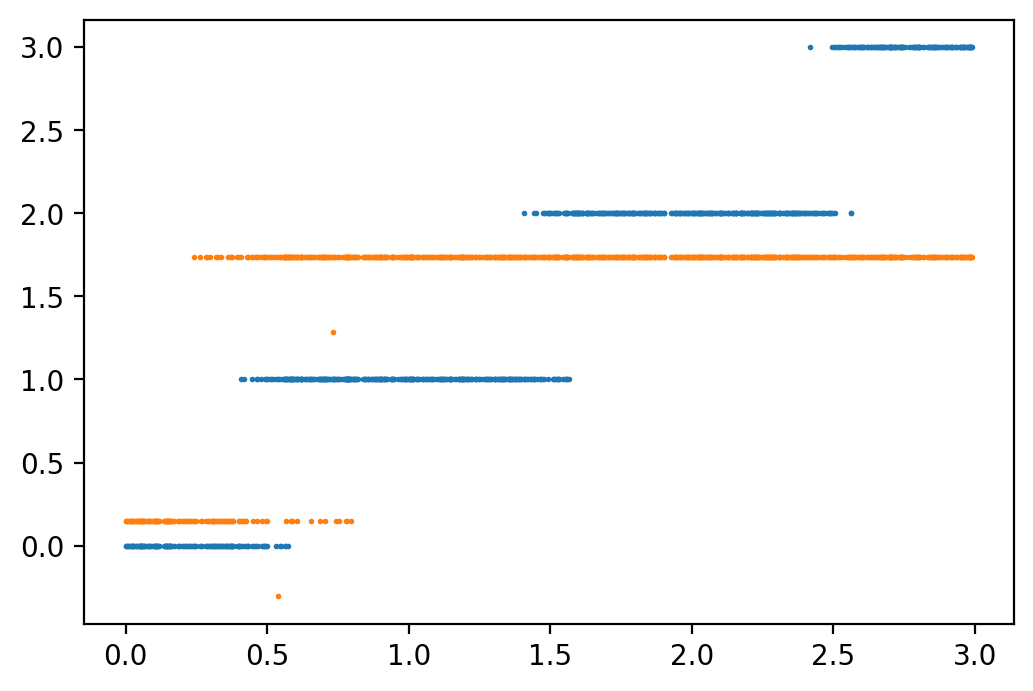

In [42]:
final_predicted = model(input_data)[0].detach().cpu().numpy()[:, 0]
plt.figure(dpi=200)
plt.scatter(input_x, output_y, s=1)
plt.scatter(input_x, final_predicted, s=1)